In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import make_cdf_map, make_norm_map, update_penguin, update_naive, make_multinorm_map

In [3]:
df = pd.read_csv(Path.cwd() / 'data' / 'penguins_raw.csv')
df['Species'] = df['Species'].replace({'Adelie Penguin (Pygoscelis adeliae)':'Adelie',
                                       'Chinstrap penguin (Pygoscelis antarctica)':'Chinstrap',
                                       'Gentoo penguin (Pygoscelis papua)':'Gentoo'})

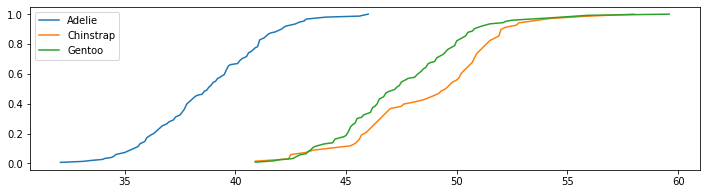

In [5]:
culmen_cdf = make_cdf_map(df, 'Culmen Length (mm)')

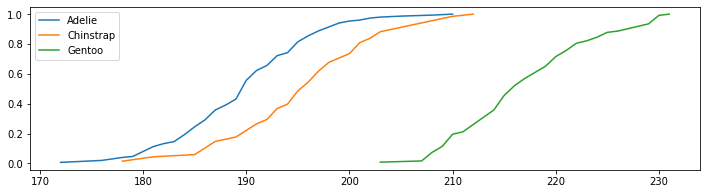

In [6]:
flipper_cdf = make_cdf_map(df, 'Flipper Length (mm)')

In [7]:
flipper_map = make_norm_map(df, 'Flipper Length (mm)')
culmen_map = make_norm_map(df, 'Culmen Length (mm)')

In [8]:
data = 193
flipper_map['Adelie'].pdf(data)

0.054732511875530694

In [10]:
hypos = flipper_map.keys()
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[0.054732511875530694, 0.051721356158881626, 5.866045366199098e-05]

In [11]:
prior = Pmf(1/3, hypos)
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


In [12]:
posterior1 = update_penguin(prior.copy(), 193, flipper_map)
posterior1

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


In [13]:
posterior2 = update_penguin(posterior1, 48, culmen_map)
posterior2

,probs
Adelie,0.003455
Chinstrap,0.995299
Gentoo,0.001246


In [14]:
colnames = ['Flipper Length (mm)', 'Culmen Length (mm)']
norm_maps = [flipper_map, culmen_map]
data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior, posterior.max_prob()

(Adelie       0.003455
 Chinstrap    0.995299
 Gentoo       0.001246
 Name: , dtype: float64,
 'Chinstrap')

In [19]:
list(df.iterrows())[0][1][colnames]

Flipper Length (mm)    181.0
Culmen Length (mm)      39.1
Name: 0, dtype: object

In [20]:
df['Classification'] = np.nan
for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob()

In [21]:
valid = df['Classification'].notna()
same = df['Species'] == df['Classification']
same.sum() / valid.sum()

0.9473684210526315

In [22]:
var1 = colnames[0]
var2 = colnames[1]
features = df[[var1, var2]]
features.head()

,Flipper Length (mm),Culmen Length (mm)
0,181.0,39.1
1,186.0,39.5
2,195.0,40.3
3,NaN,NaN
4,193.0,36.7


In [24]:
mean = features.mean()
cov = features.cov()
mean, cov

(Flipper Length (mm)    200.915205
 Culmen Length (mm)      43.921930
 dtype: float64,
                      Flipper Length (mm)  Culmen Length (mm)
 Flipper Length (mm)           197.731792           50.375765
 Culmen Length (mm)             50.375765           29.807054)

In [25]:
multinorm_map = make_multinorm_map(df, [var1, var2])
multinorm_map

{'Adelie': <scipy.stats._multivariate.multivariate_normal_frozen at 0x184d700a950>,
 'Chinstrap': <scipy.stats._multivariate.multivariate_normal_frozen at 0x184d6ff9030>,
 'Gentoo': <scipy.stats._multivariate.multivariate_normal_frozen at 0x184d6ff8c70>}

In [27]:
data = 193, 48
posterior = update_penguin(prior.copy(), data, multinorm_map)
posterior

,probs
Adelie,0.002740
Chinstrap,0.997257
Gentoo,0.000003


In [28]:
df['Classification'] = np.nan
for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_penguin(prior, data_seq, multinorm_map)
    df.loc[i, 'Classification'] = posterior.max_prob()

In [29]:
valid = df['Classification'].notna()
same = df['Species'] == df['Classification']
same.sum() / valid.sum()

0.9532163742690059